In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from pynndescent import NNDescent

from matplotlib import rcParams
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

import sys
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/')
from importlib import reload  
import helper as h
reload(h)
import helper as h

In [2]:
path_rna='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/'
path_data=path_rna+'combined/'
path_query=path_rna+'GSE137909/GEO/'
path_model=path_query+'run_scArches1603792372.695119/'

In [3]:
# Saving figures
path_fig='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/figures/paper/'

In [4]:
# load beta ct info
beta_obs=sc.read(path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad',
                 backed='r').obs.copy()
beta_uns=sc.read(path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad',
                 backed='r').uns.copy()

In [5]:
# Atlas ct colors
atlas_ct_colors=dict(zip(
     list(sc.read(path_data+'data_integrated_analysed.h5ad', backed='r'
                 ).obs['cell_type_integrated_v1'].cat.categories.copy()),
    sc.read(path_data+'data_integrated_analysed.h5ad', backed='r'
                 ).uns['cell_type_integrated_v1_colors'].copy()))

In [6]:
# Load whole data info
adata_temp=sc.read(path_data+'data_integrated_analysed.h5ad',backed='r')
adata=sc.AnnData(X=adata_temp.obsm['X_integrated'],obs=adata_temp.obs)
del adata_temp

In [7]:
# Load external adata and latent
adata_q=sc.AnnData(X=sc.read(path_model+'latent_query.h5ad').X,
                   obs=sc.read(path_query+'adata.h5ad',backed='r').obs)

In [8]:
# Load query expression
adata_q_expr=sc.read(path_query+'adata.h5ad')

In [9]:
adata

AnnData object with n_obs × n_vars = 301796 × 15
    obs: 'study_sample', 'study', 'file', 'reference', 'size_factors_sample', 'S_score', 'G2M_score', 'phase', 'phase_cyclone', 's_cyclone', 'g2m_cyclone', 'g1_cyclone', 'sex', 'pre_cell_type', 'ins_score', 'ins_high', 'gcg_score', 'gcg_high', 'sst_score', 'sst_high', 'ppy_score', 'ppy_high', 'cell_filtering', 'age', 'strain', 'tissue', 'technique', 'internal_id', 'batch', 'study_sample_design', 'cell_type', 'cell_type_multiplet', 'cell_subtype', 'cell_subtype_multiplet', 'leiden_r0.4', 'design', 'cell_type_integrated', 'cell_type_integrated_v1', 'leiden_r1', 'leiden_r1.5', 'leiden_r2', 'leiden_r0.5', 'size_factors_integrated', 'pre_cell_type_unified', 'pre_cell_type_original', 'study_parsed', 'cell_type_integrated_v1_parsed', 'cell_type_parsed'

## Cell type transfer

In [57]:
# Ct transfer
h.weighted_knn(train_adata=adata, valid_adata=adata_q, 
               label_key='cell_type_integrated_v1', label_key_valid=None,
               n_neighbors=50, threshold=0,
                 pred_unknown=False)

Weighted KNN with n_neighbors = 50 and threshold = 0 ... finished!


Predicted and reall cell counts

In [58]:
adata_q.obs['cell_type_original'].value_counts()

beta           1005
acinar          780
alpha           616
delta           255
PP              167
duct            131
immune           42
mesenchyme        2
endothelium       1
Name: cell_type_original, dtype: int64

In [59]:
adata_q.obs['pred_cell_type_integrated_v1'].value_counts()

beta                       965
embryo                     704
alpha                      632
delta                      263
gamma                      151
ductal                     118
immune                      47
beta_delta                  30
endocrine proliferative     21
embryo endocrine            16
beta_gamma                  15
alpha_delta                  9
acinar                       8
stellate_quiescent           5
endothelial                  5
ambient                      4
alpha_beta                   3
delta_gamma                  2
stellate_activated           1
Name: pred_cell_type_integrated_v1, dtype: int64

Uncertainity per ct

<AxesSubplot:xlabel='uncertainty', ylabel='cell_type_original'>

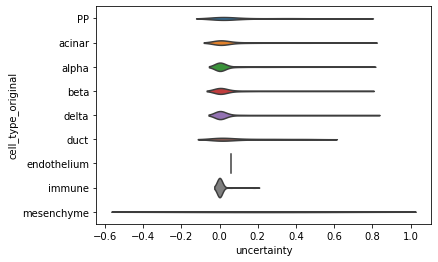

In [60]:
# uncertainity in each original ct
sb.violinplot(y='cell_type_original',x='uncertainty',data=adata_q.obs,inner=None)

<AxesSubplot:xlabel='uncertainty', ylabel='pred_cell_type_integrated_v1'>

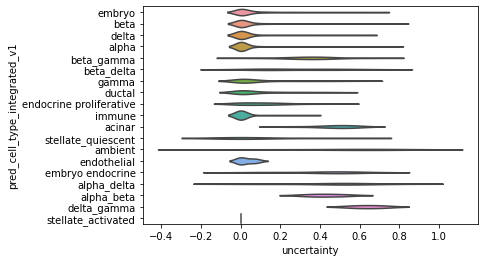

In [61]:
# uncertainity in each predicted ct
sb.violinplot(y='pred_cell_type_integrated_v1',x='uncertainty',data=adata_q.obs,inner=None)

C: As expected rare and challenging cell types (doublets, acinar) had lower certainty.

Crosstables predicted vs real - normalised by original or predicted cell type

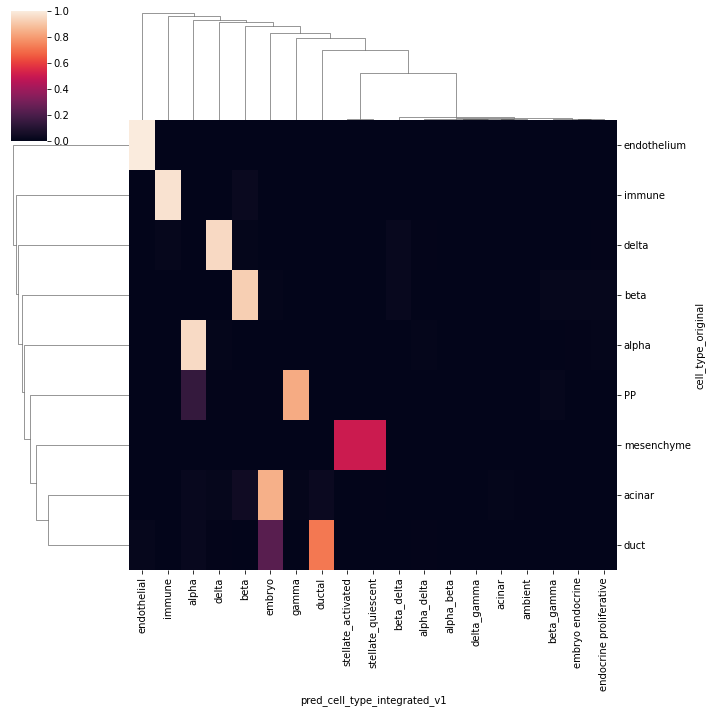

In [62]:
sb.clustermap(pd.crosstab(adata_q.obs['cell_type_original'],
               adata_q.obs['pred_cell_type_integrated_v1'],normalize='index'))

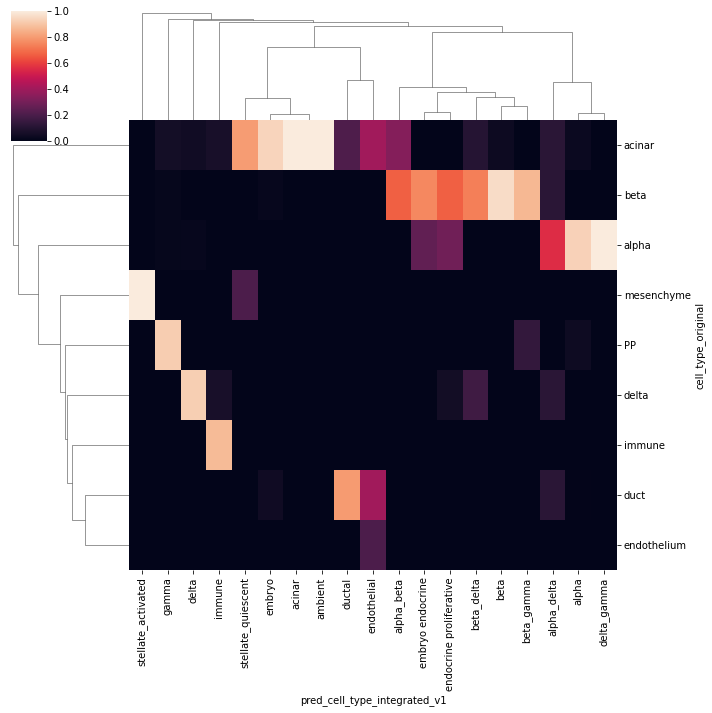

In [63]:
sb.clustermap(pd.crosstab(adata_q.obs['cell_type_original'],
               adata_q.obs['pred_cell_type_integrated_v1'],normalize='columns'))

In [74]:
# jaccard index
data=pd.DataFrame(index=adata_q.obs['cell_type_original'].unique(),
                  columns=adata_q.obs['pred_cell_type_integrated_v1'].unique())
for ct_original in adata_q.obs['cell_type_original'].unique():
    for ct_pred in adata_q.obs['pred_cell_type_integrated_v1'].unique():
        so=set(adata_q.obs.query('cell_type_original==@ct_original').index)
        sp=set(adata_q.obs.query('pred_cell_type_integrated_v1==@ct_pred').index)
        j=len(so&sp)/len(so|sp)
        data.at[ct_original,ct_pred]=j
data=data.astype(float)

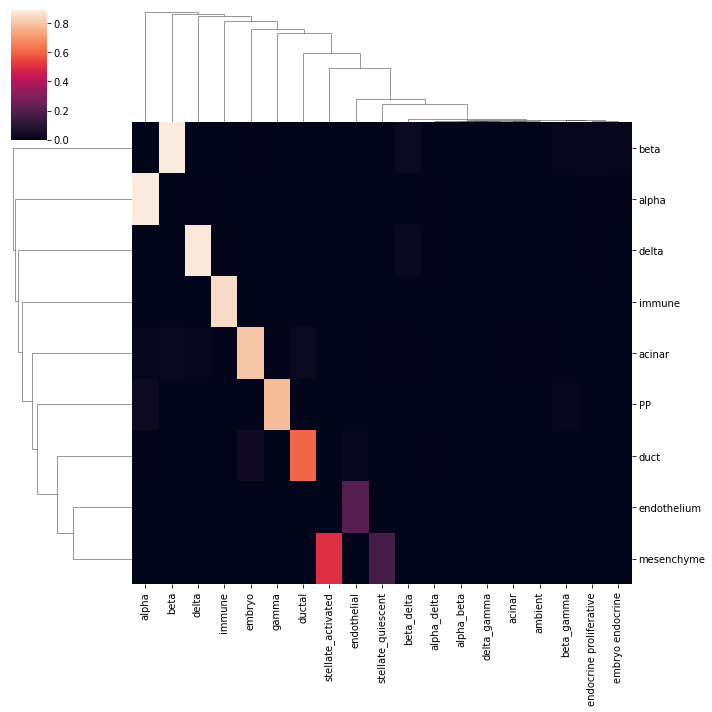

In [75]:
sb.clustermap(data)

C: Acinar predicted as embryo - maybe because embryo has more acinar cells than the postnatal acinar cluster - e.g. we did not annotate the large acinar cluster in embryo as separate cluster.

C: Mesenchymal - likely missing from our data. Cells mainly get high uncertainty so if label transfer was done with uncertainty threhold they would likely fall into uncertain rather than stellate.

C: Maybe they have a few doublets/proliferative that they did not reoslve.

### Predictions in originally annotated beta cells

See why the originally annotated beta cells also get predicted as other cell clusters. - There could be missannotated doublets/proliferative cells. Thus check for predicted clusters (within original beta cells) marker expression.

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'pred_cell_type_integrated_v1' as categorical


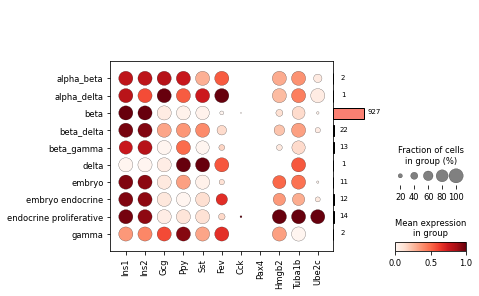

In [123]:
# markers indicative of doublets/proliferatrive
genes=['Ins1','Ins2','Gcg','Ppy','Sst','Fev','Cck','Pax4','Hmgb2','Tuba1b','Ube2c']
adata_q_expr.obs['pred_cell_type_integrated_v1']=adata_q.obs['pred_cell_type_integrated_v1']
dp=sc.pl.dotplot(
    adata_q_expr[adata_q.obs['cell_type_original']=='beta',:],
    groupby='pred_cell_type_integrated_v1', var_names=genes,gene_symbols='gene_symbol',
    standard_scale='var',return_fig=True
)
dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.2,cmap='Reds').show()

C: There are some doublets and proliferative cells and potentially some missannotation.

Certainty of prediction across beta cells per predicted ct.

<AxesSubplot:xlabel='uncertainty', ylabel='pred_cell_type_integrated_v1'>

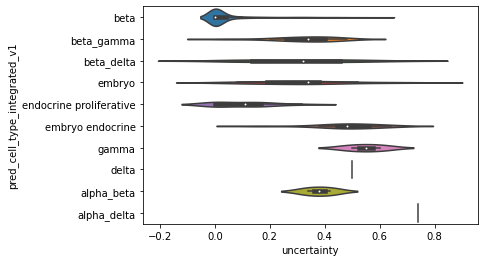

In [118]:
sb.violinplot(y=adata_q.obs.query('cell_type_original=="beta"')['pred_cell_type_integrated_v1'],
             x=adata_q.obs.query('cell_type_original=="beta"')['uncertainty'])

C: Predictions in doublet and other non-beta regions are less certain.

Per sample proportion of beta cells predicted as beta.

In [93]:
adata_q.obs.query('cell_type_original=="beta"').groupby('donor').apply(
    lambda x: (x['pred_cell_type_integrated_v1']=="beta").sum()/x.shape[0])

donor
Ngn3Cre_Control_1         0.957143
Ngn3Cre_Control_2         0.992754
Ngn3Cre_Control_3         1.000000
Ngn3Cre_P3_1              0.756098
Ngn3Cre_P12_1             0.983607
Ngn3Cre_P12_2             0.895522
Ngn3Cre_P21_1             0.933333
Ngn3Cre_STZ_D6_1          0.900000
Ngn3Cre_STZ_D12_1         0.812500
Ngn3Cre_STZ_D12_2         0.970588
Ngn3Cre_STZ_D30_1         0.892857
Ngn3Cre_STZ_D42_1         0.826087
Ngn3Cre_STZ_M2_1          1.000000
Ngn3Cre_STZ_M2_NoIns_1    0.800000
Ngn3Cre_STZ_M2_NoIns_2    0.727273
Ngn3Cre_STZ_M5_1          0.970588
Ngn3Cre_STZ_M9_1          0.947368
dtype: float64

C: Proportion of beta cells predicted as beta differ across samples. However, they are mainly relatively high so in downsteram beta cell analyses the original beta cell annotation will be used (also since prediction of non-beta cells had lower certainty).

N beta cells per sample

In [94]:
adata_q.obs.query('cell_type_original=="beta"').groupby('donor').size()

donor
Ngn3Cre_Control_1         210
Ngn3Cre_Control_2         138
Ngn3Cre_Control_3          21
Ngn3Cre_P3_1              123
Ngn3Cre_P12_1              61
Ngn3Cre_P12_2              67
Ngn3Cre_P21_1             105
Ngn3Cre_STZ_D6_1           30
Ngn3Cre_STZ_D12_1          16
Ngn3Cre_STZ_D12_2          34
Ngn3Cre_STZ_D30_1          28
Ngn3Cre_STZ_D42_1          23
Ngn3Cre_STZ_M2_1            8
Ngn3Cre_STZ_M2_NoIns_1      5
Ngn3Cre_STZ_M2_NoIns_2     11
Ngn3Cre_STZ_M5_1           68
Ngn3Cre_STZ_M9_1           57
dtype: int64

In [95]:
adata_q.obs.query('pred_cell_type_integrated_v1=="beta"').groupby('donor').size()

donor
Ngn3Cre_Control_1         201
Ngn3Cre_Control_2         145
Ngn3Cre_Control_3          21
Ngn3Cre_P3_1               99
Ngn3Cre_P12_1              62
Ngn3Cre_P12_2              60
Ngn3Cre_P21_1             101
Ngn3Cre_STZ_D6_1           30
Ngn3Cre_STZ_D12_1          13
Ngn3Cre_STZ_D12_2          36
Ngn3Cre_STZ_D30_1          25
Ngn3Cre_STZ_D42_1          19
Ngn3Cre_STZ_M2_1           20
Ngn3Cre_STZ_M2_NoIns_1      4
Ngn3Cre_STZ_M2_NoIns_2      8
Ngn3Cre_STZ_M5_1           67
Ngn3Cre_STZ_M9_1           54
dtype: int64

C: Seems that beta numbers per sample are similar in original and predicted.

Certainity of beta predictions across samples.

<AxesSubplot:xlabel='uncertainty', ylabel='donor'>

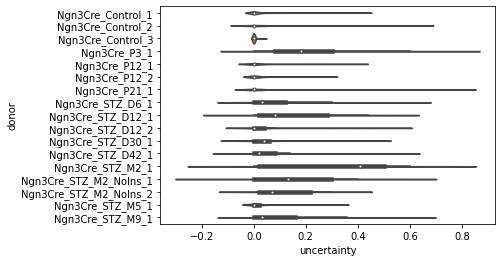

In [98]:
sb.violinplot(y=adata_q.obs.query('pred_cell_type_integrated_v1=="beta"')['donor'],
             x=adata_q.obs.query('pred_cell_type_integrated_v1=="beta"')['uncertainty'])

C: A few samples may be more affected by ct transfer uncertainty, but not all of them have many other cts annotated as beta. Hiogh uncertainty is mainly characteristics for very young (P3 - missing from the reference atlas) and STZ samples (somewhat different diabetic model tha the ones in the atlas), so this makes sense.

## Beta subtype transfer

### Coarse states
Use only beta cells from query (original anno) and ref. 

In [110]:
# Ct transfer
# Prepare data subset
adata_b=adata[adata.obs.cell_type_integrated_v1=="beta",:].copy()
ct='leiden_r1.5_parsed_const'
adata_b.obs.loc[beta_obs.index,ct]=beta_obs[ct]
adata_q_b=adata_q[adata_q.obs.cell_type_original=="beta",:].copy()
# Do transfer
h.weighted_knn(train_adata=adata_b, valid_adata=adata_q_b, 
               label_key=ct, label_key_valid=None,
               n_neighbors=50, threshold=0,
                 pred_unknown=False)

Weighted KNN with n_neighbors = 50 and threshold = 0 ... finished!


Predicted cell counts

In [111]:
adata_q_b.obs['pred_'+ct].value_counts()

T2D             293
spikein_chem    262
young           198
adult           167
old_male         77
T1D               6
low_quality       1
old_female        1
Name: pred_leiden_r1.5_parsed_const, dtype: int64

Uncertainity 

<AxesSubplot:xlabel='uncertainty', ylabel='pred_leiden_r1.5_parsed_const'>

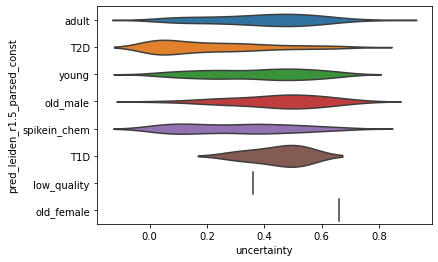

In [113]:
sb.violinplot(y='pred_'+ct,x='uncertainty',data=adata_q_b.obs,inner=None)

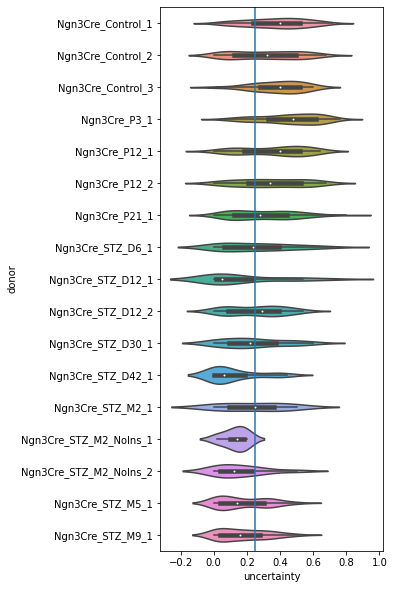

In [153]:
rcParams['figure.figsize']=(4,10)
sb.violinplot(y='donor',x='uncertainty',data=adata_q_b.obs)
plt.axvline(0.25)

C: in some cases seems that cells separated in high and low certainty regions, splitting at arround 0.25

Predicted ct per sample

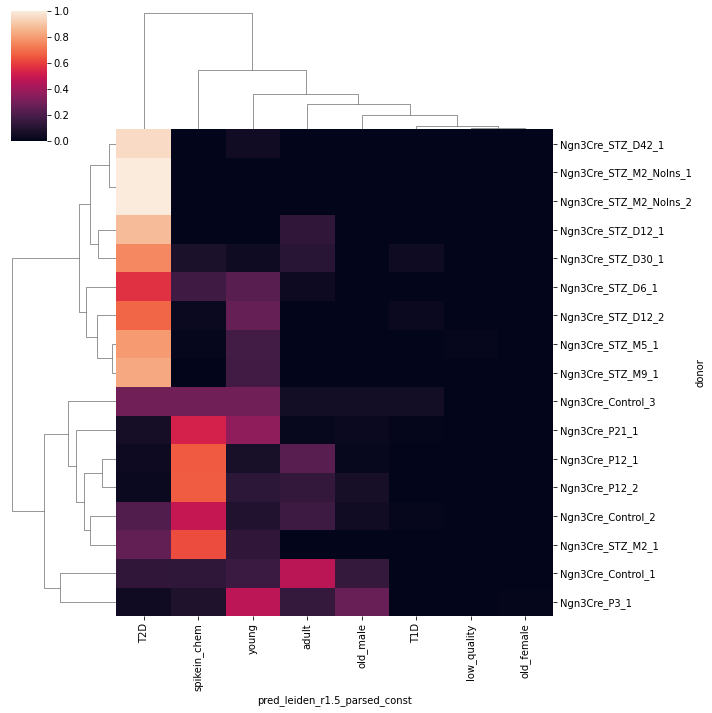

In [115]:
sb.clustermap(pd.crosstab(adata_q_b.obs['donor'],
               adata_q_b.obs['pred_'+ct],normalize='index'))

C: Some odd predictions like P3 predicted as young and old_male. Maybe due to not performing uncertainty filtering so this is just random prediction (e.g. this state is likely missing from our beta cells)? - Indeed, this sample has high uncertainty.

Uncertainty in each sample for predicted cts

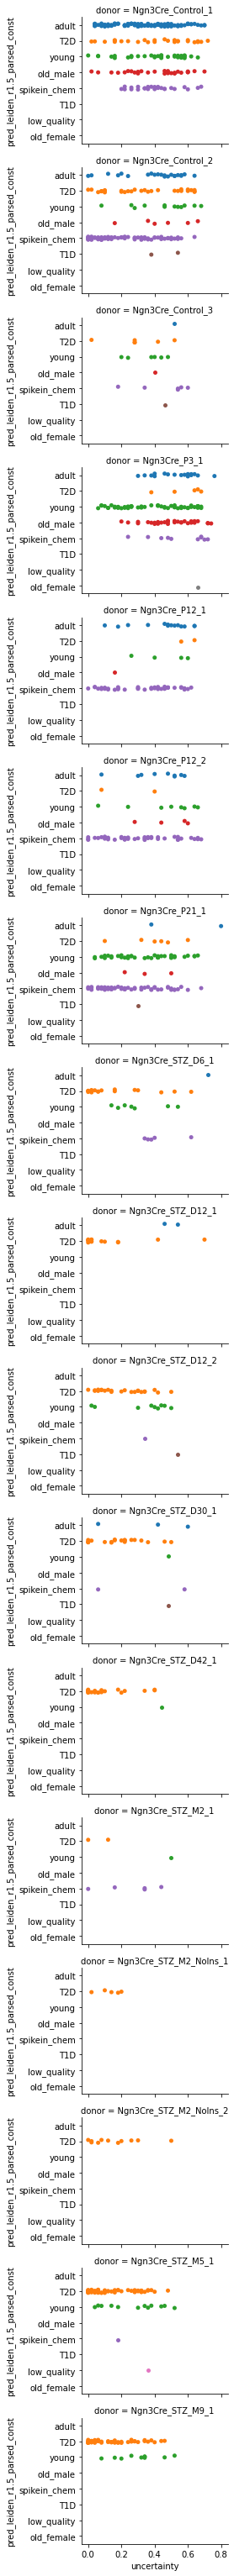

In [129]:
sb.catplot(x="uncertainty", y="pred_"+ct,row="donor",
                data=adata_q_b.obs,
                height=2.5, aspect=1.5);

#### Certainty filtering
Use as predicted only uncertainty<0.25

In [156]:
# Ct transfer
# Prepare data subset
adata_b=adata[adata.obs.cell_type_integrated_v1=="beta",:].copy()
ct='leiden_r1.5_parsed_const'
adata_b.obs.loc[beta_obs.index,ct]=beta_obs[ct]
adata_q_b=adata_q[adata_q.obs.cell_type_original=="beta",:].copy()
# Do transfer
h.weighted_knn(train_adata=adata_b, valid_adata=adata_q_b, 
               label_key=ct, label_key_valid=None,
               n_neighbors=50, threshold=0.75,
                 pred_unknown=True)

Weighted KNN with n_neighbors = 50 and threshold = 0.75 ... finished!


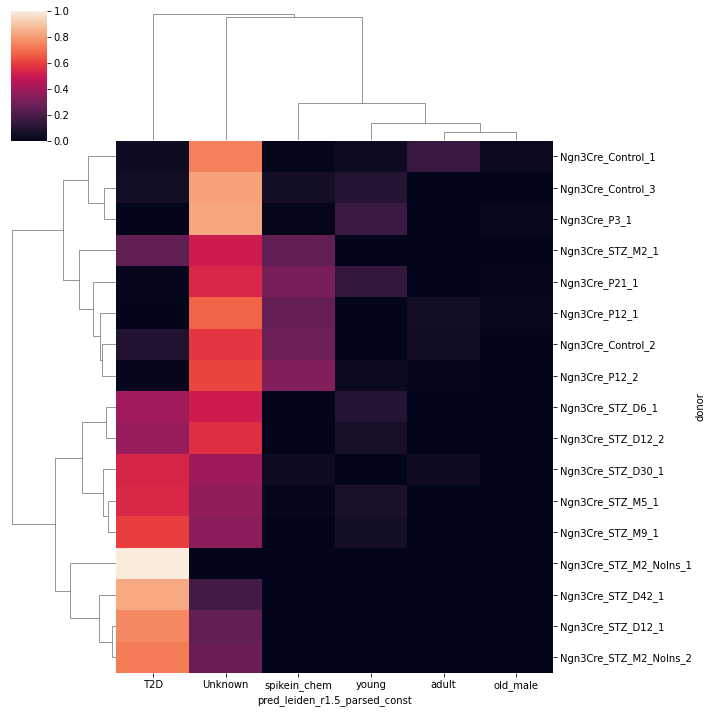

In [157]:
sb.clustermap(pd.crosstab(adata_q_b.obs['donor'],
               adata_q_b.obs['pred_'+ct],normalize='index'))

C: If set to unknown many cells are unpredicted, but see that STZ mainly map on T2D not T1D.

C: Interestingly, older controls mainly map on spikein_chem cluster. The uncertainty of prediction is high, but consistent across cells. There must be also other cts among neighbours quite often. Maybe also problem of ct number inbalance as the prediction is based on KNN classification??

C: Some STZ get predicted as young - expected.

#### Decipher P3 cells
Joint embedding to see where beta cells from individual query samples map relative to ref

In [24]:
adata_full=sc.concat([adata_q[adata_q.obs.cell_type=='beta',:],
                       adata[adata.obs.cell_type_integrated_v1=="beta",:]],
                      index_unique='-',keys=['query','ref'],join='outer',label='ref_query')

In [32]:
sc.pp.neighbors(adata_full, n_neighbors=15,)
sc.tl.umap(adata_full,min_dist=0, spread=1, )

Plot ref/query, reference study, and query donor.

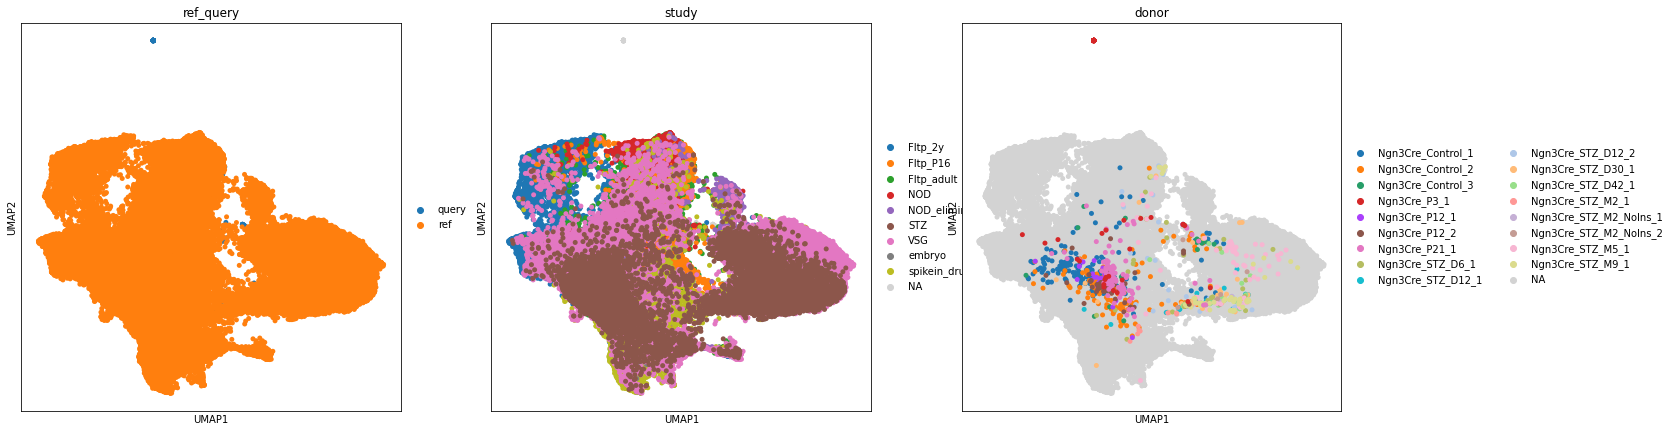

In [34]:
rcParams['figure.figsize']=(7,7)
sc.pl.umap(adata_full,color=['ref_query','study','donor'],s=100)

C: Part of P3 cells map separately from beta cells

Which cells map separately?

(array([ 327.,  565.,  439.,  817., 1305., 2667., 1804., 1494., 1553.,
        1458., 1339., 2406., 4328., 5358., 5640., 5410., 4998., 5083.,
        4976., 4638., 5064., 5769., 3683., 2273., 1883., 1847., 2423.,
        2746., 2373., 2174., 2257., 2714., 3201., 2807., 2674., 2128.,
         428.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,   99.]),
 array([ 2.5891492,  2.855377 ,  3.1216047,  3.3878324,  3.6540601,
         3.920288 ,  4.186516 ,  4.4527435,  4.7189713,  4.985199 ,
         5.2514267,  5.5176544,  5.783882 ,  6.05011  ,  6.3163376,
         6.5825653,  6.848793 ,  7.1150208,  7.3812485,  7.647476 ,
         7.913704 ,  8.179932 ,  8.446159 ,  8.712387 ,  8.978615 ,
         9.244843 ,  9.51107  ,  9.777298 , 10.043526 , 10.309753 ,
        10.575981 , 10.84221  , 11.108438 , 11.374665 , 11.640893 ,
        11.907121 , 12.173348 , 12.439576 , 12.705804 , 12.972032 ,
        13.238259 , 13.504487 , 13.770715 , 14.0369425, 

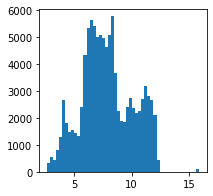

In [48]:
# UMAP location distn - which cells are outliers
rcParams['figure.figsize']=(3,3)
plt.hist(adata_full.obsm['X_umap'][:,1],bins=50)

In [47]:
# Based on UMAp outliers identify separately mapping P3
print('N P3 cells mapping separately:',
      (adata_full[adata_full.obs.donor=='Ngn3Cre_P3_1',:].obsm['X_umap'][:,1]>15).sum(),
      'or together with ref cells:',
      (adata_full[adata_full.obs.donor=='Ngn3Cre_P3_1',:].obsm['X_umap'][:,1]<15).sum())

N P3 cells mapping separately: 99 or together with ref cells: 24


C: P3 map separately. But P12-21 cells map to adult/spikein drug regions. STZ map clearly to the T2D cluster.

Check if P3 is more proliferative/embryo - do proliferative/embryo cells need to be included for ct transfer?

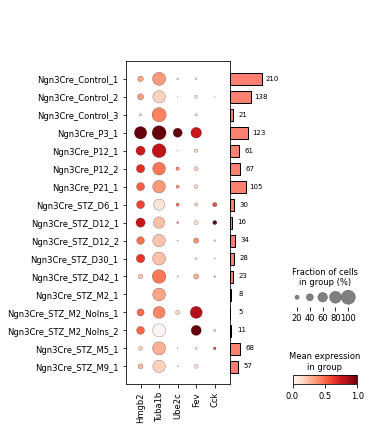

In [58]:
genes=['Hmgb2','Tuba1b','Ube2c','Fev','Cck']
dp=sc.pl.dotplot(
    adata_q_expr[adata_q.obs['cell_type_original']=='beta',:],
    groupby='donor', var_names=genes,gene_symbols='gene_symbol',
    standard_scale='var',return_fig=True
)
dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.2,cmap='Reds').show()

C: May be that P3 is more proliferative/embryo

###  Mapping of query healthy controls and diseased

In [10]:
# joint adata
adata_full3=sc.concat([adata_q[(adata_q.obs.cell_type=='beta').values &
                              (adata_q.obs.donor.str.contains('Control').values |
                               adata_q.obs.donor.str.contains('STZ').values),:],
                       adata[adata.obs.cell_type_integrated_v1=="beta",:]],
                      index_unique='-',keys=['query','ref'],join='outer',label='ref_query')

In [12]:
# joint embedding
sc.pp.neighbors(adata_full3, n_neighbors=15,)
sc.tl.umap(adata_full3,min_dist=0, spread=1, )

In [26]:
# Subset cells - remove low Q beta from ref
print("N all cells:",adata_full3.shape[0])
lowq_cells=set(beta_obs.index[beta_obs['leiden_r1.5_parsed_const'].str.contains('low_quality')])
no_lowq_cells=set([c for c  in adata_full3.obs_names 
                   if c.replace('-ref','') not in lowq_cells])
print('N no lowQ cells:',len(no_lowq_cells))

N all cells: 102792
N no lowQ cells: 100010


Plot fine clusters from ref

In [22]:
# Add beta subtype info
adata_full3.obs.loc[beta_obs.index.to_series().apply(lambda x: x+'-ref').values,
                    'hc_gene_programs_parsed']=\
    beta_obs['hc_gene_programs_parsed'].values
adata_full3.obs['hc_gene_programs_parsed']=pd.Categorical(
    values=adata_full3.obs['hc_gene_programs_parsed'],
categories=beta_uns['hc_gene_programs_parsed_order'],ordered=True)
adata_full3.uns['hc_gene_programs_parsed_colors']=beta_uns['hc_gene_programs_parsed_colors']

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'strain' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categori

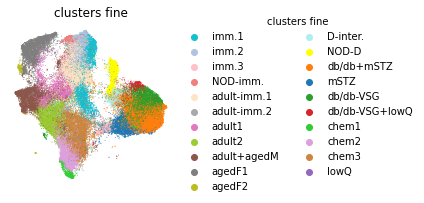

In [27]:
rcParams['figure.figsize']=(3,3)
# Reset categories for plotting to get matched palete as before
adata_temp=adata_full3[~adata_full3.obs['hc_gene_programs_parsed'].isna(),:].copy()
adata_temp=adata_temp[[c for c in adata_temp.obs_names if c in no_lowq_cells],:]
np.random.seed(0)
random_indices=np.random.permutation(list(range(adata_temp.shape[0])))
g=sc.pl.umap(adata_temp[random_indices,:],color=['hc_gene_programs_parsed'],s=3, 
           frameon=False, title='clusters fine',show=False)
del adata_temp
g.legend_.set_title('clusters fine')
plt.savefig(path_fig+'umap_transferedMouse_beta_CLfine.png',dpi=300,bbox_inches='tight')

C: Due to small N of query cells the embeddings looks almost identical to only ref embedding

Healthy and diseased query plot

In [28]:
# Make query groups
adata_full3.obs['query_group']=adata_full3.obs.donor.apply(
    lambda x: 'STZ' if 'STZ' in x else 'healthy control' if 'Control' in x  else np.nan)
adata_full3.obs['query_group']=pd.Categorical(
values=adata_full3.obs['query_group'],categories=['healthy control','STZ'])
adata_full3.uns['query_group_colors']=['#8BBD0C','#C72323']

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'strain' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'age' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_cat

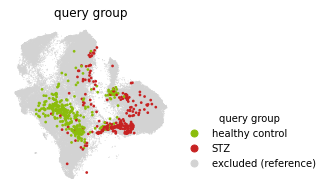

In [30]:
# Plot query groups
fig,ax=plt.subplots(figsize=(3,3))
np.random.seed(0)
adata_temp=adata_full3[~adata_full3.obs['hc_gene_programs_parsed'].isna(),:]
adata_temp=adata_temp[[c for c in adata_temp.obs_names if c in no_lowq_cells],:].copy()
sc.pl.umap(adata_temp,s=3, 
           frameon=False, show=False,ax=ax)
adata_temp=adata_full3[~adata_full3.obs['query_group'].isna(),:].copy()
adata_temp=adata_temp[[c for c in adata_temp.obs_names if c in no_lowq_cells],:]
random_indices=np.random.permutation(list(range(adata_temp.shape[0])))
sc.pl.umap(adata_temp[random_indices,:],color=['query_group'],s=30, 
           frameon=False, title='query group',show=False,ax=ax)
ax.legend_.remove()
l1=ax.legend(handles=[
    Line2D([0], [0], marker='o', color=c,lw=0, label=l,
    markerfacecolor=c, markersize=7) for l,c in zip(
        list(adata_temp.obs.query_group.cat.categories)+['excluded (reference)'],
        list(adata_temp.uns['query_group_colors'])+['lightgray']
    )], frameon=False,bbox_to_anchor=(1,0.5),title='query group')
plt.savefig(path_fig+'umap_transferedMouse_beta_queryHD.png',dpi=300,bbox_inches='tight')

del adata_temp

### Transfer from embryo, postnatal, and proliferative beta cells
Since P3 can not be predicted by postnatal beta cells try prediction with also other cell groups (embryo and proliferative beta cells).

Use beta (atlas annotation), embryo beta (original embryo dataset annotation of cells in embryo endocrine atlas cluster), and proliferative (cells that are ins high but not high for other hormones).

In [16]:
# prepare joint data
adata_full2=sc.concat([
    adata_q[adata_q.obs.cell_type=='beta',:],
    adata[(adata.obs.cell_type_integrated_v1=="beta").values |
          ((adata.obs.pre_cell_type_original=="Beta").values &
           (adata.obs.study=="embryo").values &
           (adata.obs.cell_type_integrated_v1=="embryo endocrine").values) |
          ((adata.obs.cell_type_integrated_v1=="endocrine proliferative").values &
           (adata.obs.ins_high).values &
            ~(adata.obs.gcg_high).values &
            ~(adata.obs.ppy_high).values &
            ~(adata.obs.sst_high).values ), :]
  ],
  index_unique='-',keys=['query','ref'],join='outer',label='ref_query')

In [17]:
adata_full2.shape

(104714, 15)

#### Joint embedding

In [18]:
sc.pp.neighbors(adata_full2, n_neighbors=15,)
sc.tl.umap(adata_full2 )

In [19]:
sc.tl.umap(adata_full2 )

In [20]:
# Add ref cell states
for cl in ['hc_gene_programs_parsed','leiden_r1.5_parsed']:
    if cl in adata_full2.obs.columns:
        adata_full2.obs.drop(cl,axis=1,inplace=True)
    adata_full2.obs.loc[beta_obs.index.to_series().apply(lambda x: x+'-ref').values,
                    cl]= beta_obs[cl].values.astype(str)

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'strain' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categori

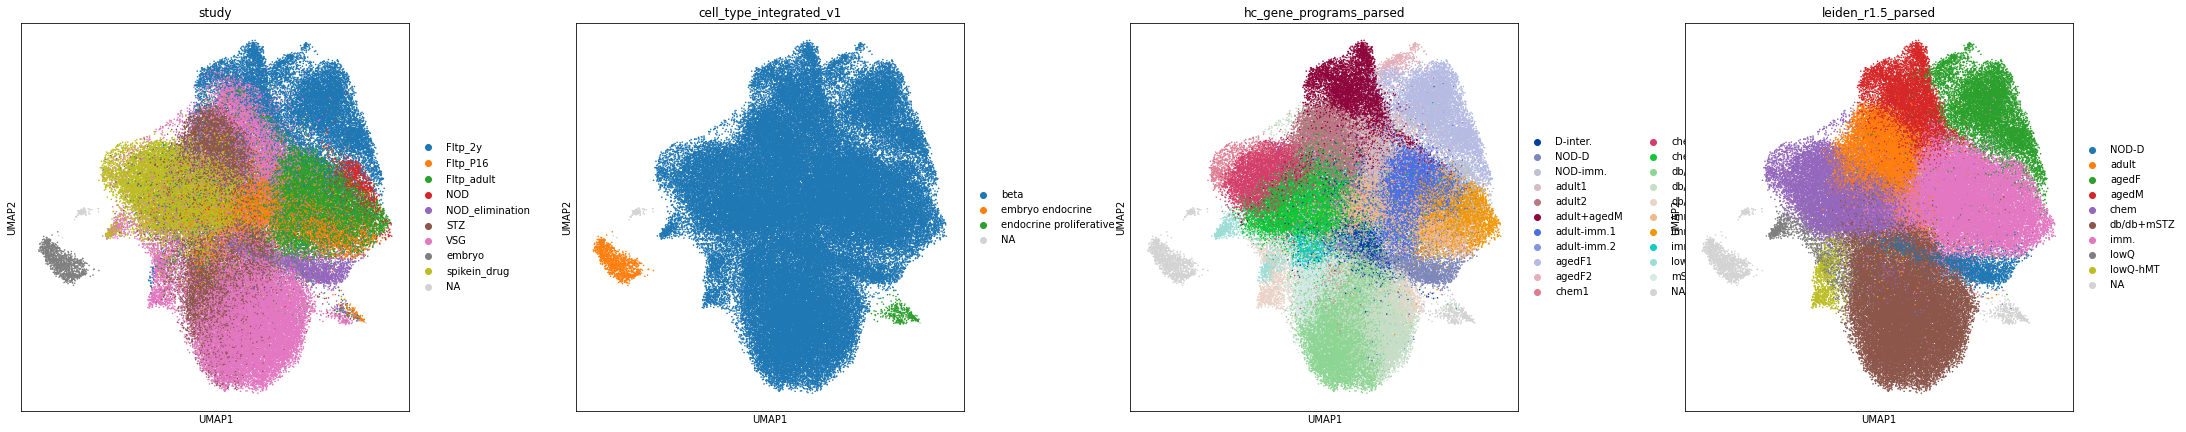

In [21]:
# plot ref cell states and studies
rcParams['figure.figsize']=(7,7)
random_indices=np.random.permutation(list(range(adata_full2.shape[0])))
sc.pl.umap(adata_full2[random_indices,:],
           color=['study','cell_type_integrated_v1','hc_gene_programs_parsed',
                  'leiden_r1.5_parsed'],
           wspace=0.3,s=10)

Reference cell type info - coarse beta cell clusters or cell type clusters

In [22]:
# Add group info - subtype and ct for other beta
adata_full2.obs['ref_group_coarse']=adata_full2.obs['leiden_r1.5_parsed']
adata_full2.obs['ref_group_coarse']=adata_full2.obs.apply(
    lambda x: x['ref_group_coarse'] if  isinstance(x['ref_group_coarse'],str) 
    else x['cell_type_integrated_v1'],axis=1).replace(
    {'embryo endocrine':'E beta','endocrine proliferative':'beta prolif.'})
# Plotting order and colors
adata_full2.obs['ref_group_coarse']=pd.Categorical(
    values=adata_full2.obs['ref_group_coarse'],
    categories=['E beta','beta prolif.'
               ]+list(beta_uns['leiden_r1.5_parsed_order']),
    ordered=True)
adata_full2.uns['ref_group_coarse_colors']=['lightsalmon','thistle'
                                    ]+list(beta_uns['leiden_r1.5_parsed_colors'])

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'strain' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categori

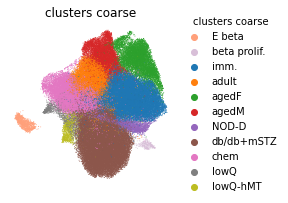

In [23]:
# Plot
rcParams['figure.figsize']=(3,3)
# Reset categories for plotting to get matched palete as before
adata_temp=adata_full2[~adata_full2.obs['ref_group_coarse'].isna(),:].copy()
np.random.seed(0)
random_indices=np.random.permutation(list(range(adata_temp.shape[0])))
g=sc.pl.umap(adata_temp[random_indices,:],color=['ref_group_coarse'],s=3, 
           frameon=False, title='clusters coarse',show=False)
del adata_temp
g.legend_.set_title('clusters coarse')
plt.savefig(path_fig+'umap_transferedMouse_betaExtended_CLcoarse.png',dpi=300,
            bbox_inches='tight')

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'strain' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categori

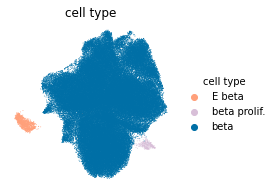

In [26]:
# Add group info - subtype and ct for other beta
adata_full2.obs['ref_group_ct']=adata_full2.obs['cell_type_integrated_v1'].replace(
    {'embryo endocrine':'E beta','endocrine proliferative':'beta prolif.'})
# Plotting order and colors
adata_full2.obs['ref_group_ct']=pd.Categorical(
    values=adata_full2.obs['ref_group_ct'],
    categories=['E beta','beta prolif.','beta'],
    ordered=True)
adata_full2.uns['ref_group_ct_colors']=['lightsalmon','thistle',atlas_ct_colors['beta']]

# Plot
rcParams['figure.figsize']=(3,3)
# Reset categories for plotting to get matched palete as before
adata_temp=adata_full2[~adata_full2.obs['ref_group_ct'].isna(),:].copy()
np.random.seed(0)
random_indices=np.random.permutation(list(range(adata_temp.shape[0])))
g=sc.pl.umap(adata_temp[random_indices,:],color=['ref_group_ct'],s=3, 
           frameon=False, title='cell type',show=False)
del adata_temp
g.legend_.set_title('cell type')
plt.savefig(path_fig+'umap_transferedMouse_betaExtended_CLcelltype.png',dpi=300,
            bbox_inches='tight')

Query samples

In [27]:
# Make query groups
# Add metadata and replicate info
group_map={}
# Which samples need rep number
duplicated=adata_q.obs.drop_duplicates('donor').apply(
    lambda data: data['age'].replace(' ','')+('_STZ' if data['STZ'] else '')+(
        '+ins' if data['insulin_implant'] else ''),axis=1).value_counts()
duplicated=set(duplicated[duplicated>1].index)
for i,data in adata_q.obs.drop_duplicates('donor').iterrows():
    donor=data['donor']
    group=data['age'].replace(' ','')+('_STZ' if data['STZ'] else '')+(
        '+ins' if data['insulin_implant'] else '')
    if group in duplicated:
        rep=data['batch']
        # replace some rep info as they specify rep 1,2,3 across ages - I want per age
        if group=='4m':
            rep=rep-1
        group=group+'_r'+str(rep)
    group_map[donor]=group
print(group_map)
# Map to data
adata_full2.obs['query_group']=adata_full2.obs.donor.map(group_map)
# Set categories
# Get categories order
age_map={a:h.age_months(a) for a in adata_q.obs['age'].unique()}
# Remove categories before age assignment to enable sorting
if 'age_months' in adata_q.obs.columns:
    adata_q.obs.drop('age_months',axis=1,inplace=True)
adata_q.obs['age_months']=adata_q.obs['age'].map(age_map).astype(float)
adata_q.obs['age_months']=pd.Series(adata_q.obs['age_months'])
# Order by STZ, ins, age, batch 
donor_order=adata_q.obs.drop_duplicates('donor').\
    sort_values(['STZ','insulin_implant','age_months','batch'],
               ascending=[True,False,True,True]).donor
cat_order=[adata_full2.obs.query('donor==@d')['query_group'][0] for d in donor_order]
# Sort categories
adata_full2.obs['query_group']=pd.Categorical(
    values=adata_full2.obs['query_group'],categories=cat_order,ordered=True)

{'Ngn3Cre_Control_1': '2m', 'Ngn3Cre_Control_2': '4m_r1', 'Ngn3Cre_Control_3': '4m_r2', 'Ngn3Cre_STZ_D12_1': '2.4m_STZ+ins', 'Ngn3Cre_STZ_D12_2': '2.77m_STZ+ins', 'Ngn3Cre_STZ_D30_1': '3m_STZ+ins', 'Ngn3Cre_STZ_D42_1': '3.4m_STZ+ins', 'Ngn3Cre_STZ_D6_1': '2.2m_STZ+ins', 'Ngn3Cre_STZ_M2_1': '4m_STZ+ins', 'Ngn3Cre_STZ_M2_NoIns_1': '4m_STZ_r1', 'Ngn3Cre_STZ_M2_NoIns_2': '4m_STZ_r2', 'Ngn3Cre_STZ_M5_1': '7m_STZ+ins', 'Ngn3Cre_STZ_M9_1': '11m_STZ+ins', 'Ngn3Cre_P12_1': '12d_r1', 'Ngn3Cre_P12_2': '12d_r2', 'Ngn3Cre_P21_1': '21d', 'Ngn3Cre_P3_1': '3d'}


/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'strain' as categorical
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categori

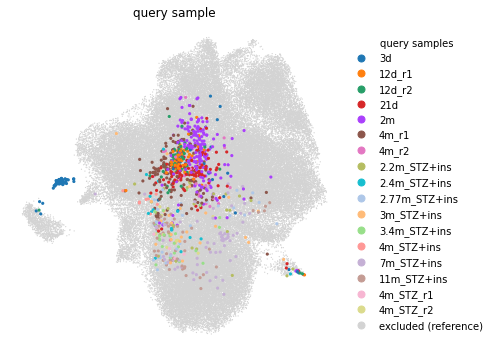

In [28]:
# Plot query groups
fig,ax=plt.subplots(figsize=(6,6))
np.random.seed(0)
sc.pl.umap(adata_full2[adata_full2.obs['query_group'].isna(),:],s=6, 
           frameon=False, show=False,ax=ax)
adata_temp=adata_full2[~adata_full2.obs['query_group'].isna(),:].copy()
random_indices=np.random.permutation(list(range(adata_temp.shape[0])))
adata_temp=adata_temp[random_indices,:]
sc.pl.umap(adata_temp,color=['query_group'],s=40, 
           frameon=False, title='query sample',show=False,ax=ax)
ax.legend_.remove()
l1=ax.legend(handles=[
    Line2D([0], [0], marker='o', color=c,lw=0, label=l,
    markerfacecolor=c, markersize=7) for l,c in zip(
        list(adata_temp.obs.query_group.cat.categories)+['excluded (reference)'],
        list(adata_temp.uns['query_group_colors'])+['lightgray']
    )], frameon=False,bbox_to_anchor=(1,0.98),title='query samples')
plt.savefig(path_fig+'umap_transferedMouse_betaExtended_queryDonors.png',dpi=300,bbox_inches='tight')

del adata_temp

C: It seems that P3 has both embryo-like and proliferative cells.

#### Ct transfer

##### No uncertainity filter

In [354]:
# Ct transfer
# Prepare data subset
ct='ref_group_coarse'
adata_b_r=adata_full2[adata_full2.obs.ref_query=='ref',:].copy()
adata_b_q=adata_full2[adata_full2.obs.ref_query=='query',:].copy()
# Do transfer
h.weighted_knn(train_adata=adata_b_r, valid_adata=adata_b_q, 
               label_key=ct, label_key_valid=None,
               n_neighbors=50, threshold=0,
                 pred_unknown=False)

Weighted KNN with n_neighbors = 50 and threshold = 0 ... finished!


Predicted cell counts

In [356]:
adata_b_q.obs['pred_'+ct].value_counts()

dbdb+STZ              288
chem                  253
immature              188
adult                 164
oldM                   71
beta embryo            17
beta proliferative     15
NOD                     6
oldF                    2
lowQ                    1
Name: pred_ref_group_coarse, dtype: int64

Uncertainity 

<AxesSubplot:xlabel='uncertainty', ylabel='pred_ref_group_coarse'>

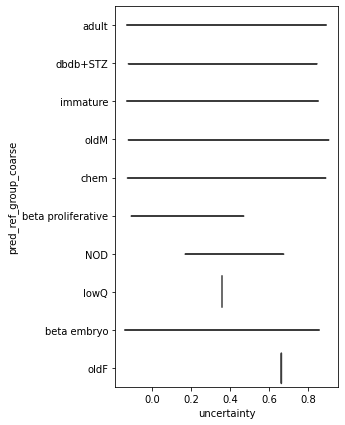

In [363]:
rcParams['figure.figsize']=(4,7)
sb.violinplot(y='pred_'+ct,x='uncertainty',data=adata_b_q.obs,inner=None)

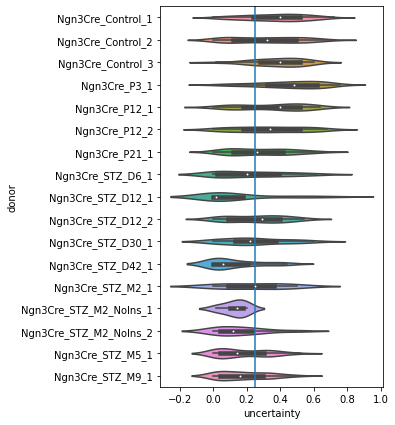

In [364]:
rcParams['figure.figsize']=(4,7)
sb.violinplot(y='donor',x='uncertainty',data=adata_b_q.obs)
plt.axvline(0.25)

C: Cells seem to separate across samples into high and low uncertainty

Predicted ct per sample

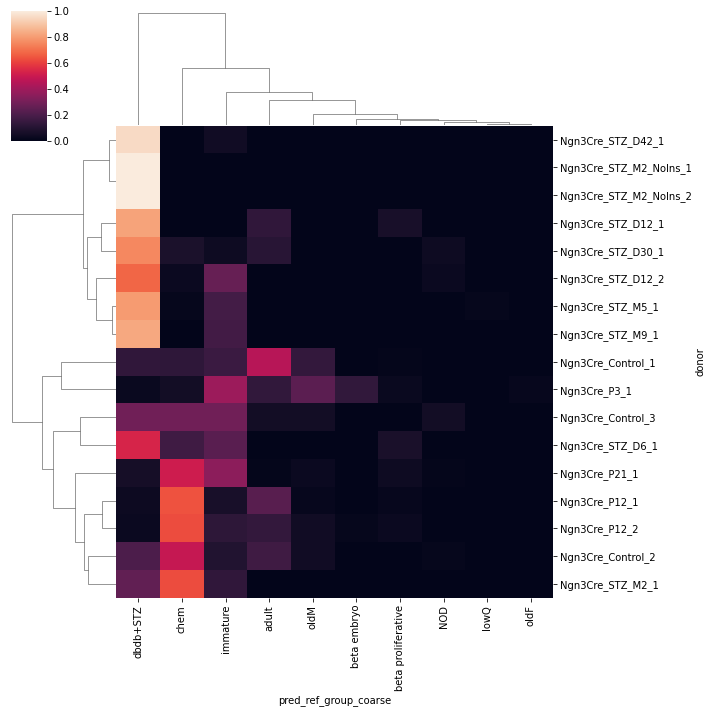

In [365]:
sb.clustermap(pd.crosstab(adata_b_q.obs['donor'],
               adata_b_q.obs['pred_'+ct],normalize='index'))

##### Uncertainity filter 
Predict with uncertainty filter based on above determined threshold

In [29]:
# Ct transfer
# Prepare data subset
ct='ref_group_coarse'
adata_b_r=adata_full2[adata_full2.obs.ref_query=='ref',:].copy()
adata_b_q=adata_full2[adata_full2.obs.ref_query=='query',:].copy()
# Do transfer
h.weighted_knn(train_adata=adata_b_r, valid_adata=adata_b_q, 
               label_key=ct, label_key_valid=None,
               n_neighbors=50, threshold=0.75,
                 pred_unknown=True)

Weighted KNN with n_neighbors = 50 and threshold = 0.75 ... finished!


Predicted cell counts

In [30]:
adata_b_q.obs['pred_'+ct].value_counts()

Unknown         591
db/db+mSTZ      180
chem            115
imm.             50
adult            41
beta prolif.     14
agedM            11
E beta            3
Name: pred_ref_group_coarse, dtype: int64

Uncertainity 

<AxesSubplot:xlabel='uncertainty', ylabel='pred_ref_group_coarse'>

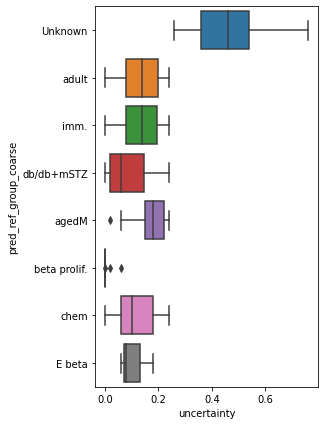

In [31]:
rcParams['figure.figsize']=(4,7)
sb.boxplot(y='pred_'+ct,x='uncertainty',data=adata_b_q.obs)

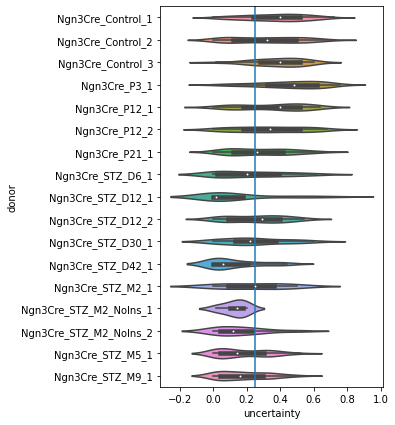

In [32]:
rcParams['figure.figsize']=(4,7)
sb.violinplot(y='donor',x='uncertainty',data=adata_b_q.obs)
plt.axvline(0.25)

Predicted ct per sample

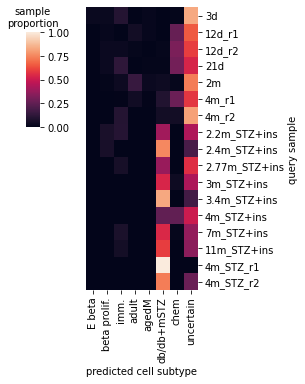

In [33]:
# Parse predicted ct to ensure ordering
adata_b_q.obs['pred_'+ct+'_parsed']=pd.Categorical(
    values=adata_b_q.obs['pred_'+ct].replace({'Unknown':'uncertain'}),
    categories=list(adata_b_r.obs[ct].cat.categories)+['uncertain'],ordered=True)
# Prediction normalized by sample
data=pd.crosstab(adata_b_q.obs['query_group'],
               adata_b_q.obs['pred_'+ct+'_parsed'],normalize='index')

# plot
w_dend=1.5
nrow=data.shape[0]*0.3
ncol=data.shape[1]*0.33
w=ncol+w_dend
h=nrow+w_dend
g=sb.clustermap(data, xticklabels=True,yticklabels=True,
                col_cluster=False,row_cluster=False,
           figsize=(w,h),dendrogram_ratio=(w_dend/w,w_dend/h),
          vmin=0,vmax=1, cbar_pos=(0.05,0.55,0.05,0.2))

g.ax_cbar.set_title('sample\nproportion',fontsize=10)
g.ax_heatmap.set_ylabel('query sample')
g.ax_heatmap.set_xlabel('predicted cell subtype')
#remove dendrogram
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)

# Save
plt.savefig(path_fig+'heatmap_transferedMouse_betaExtended_predCLcoarse.png',
            dpi=300,bbox_inches='tight')

##### PAGA
Since many cells are "uncertain" but map to the reference embedding they mnay be located between groups. Thus make PAGA of reference and query groups.

In [114]:
# Paga group info
adata_full2.obs.loc[beta_obs.index.to_series().apply(lambda x: x+'-ref').values,'group']=\
    beta_obs['hc_gene_programs_parsed'].values.astype(str)
adata_full2.obs.loc[
    adata_full2.obs_names[((adata_full2.obs.pre_cell_type_original=="Beta").values &
           (adata_full2.obs.study=="embryo").values)],'group'] = 'embryo'
adata_full2.obs.loc[
    adata_full2.obs_names[ 
        ((adata_full2.obs.cell_type_integrated_v1=="endocrine proliferative").values &
           (adata_full2.obs.ins_high.fillna(False)).values &
            ~(adata_full2.obs.gcg_high.fillna(False)).values &
            ~(adata_full2.obs.ppy_high.fillna(False)).values &
            ~(adata_full2.obs.sst_high.fillna(False)).values )],'group']='proliferative'
adata_full2.obs.loc[adata_q[adata_q.obs.cell_type=='beta',:].obs_names.to_series().apply(
    lambda x: x+'-query').values,'group']=\
    adata_q[adata_q.obs.cell_type=='beta',:].obs['donor'].values.astype(str)

In [117]:
# Compute paga
clustering='group'
sc.tl.paga(adata_full2,groups=clustering)

Plot of query vs ref similarities as PAGA graph would be hard to look at (many intertwined groups) . Thus plot PAGA connectivities as heatmap.

In [135]:
# Get connectivities
groups=adata_full2.obs[adata_full2.uns['paga']['groups']].cat.categories
data=pd.DataFrame(adata_full2.uns['paga']['connectivities'].todense(),
                  index=groups,columns=groups)
# Subset to query in rows and ref in cols
groups_q=adata_full2.obs.query('ref_query=="query"')[adata_full2.uns['paga']['groups']].unique()
groups_r=adata_full2.obs.query('ref_query=="ref"')[adata_full2.uns['paga']['groups']].unique()
data=data.loc[groups_q,groups_r]

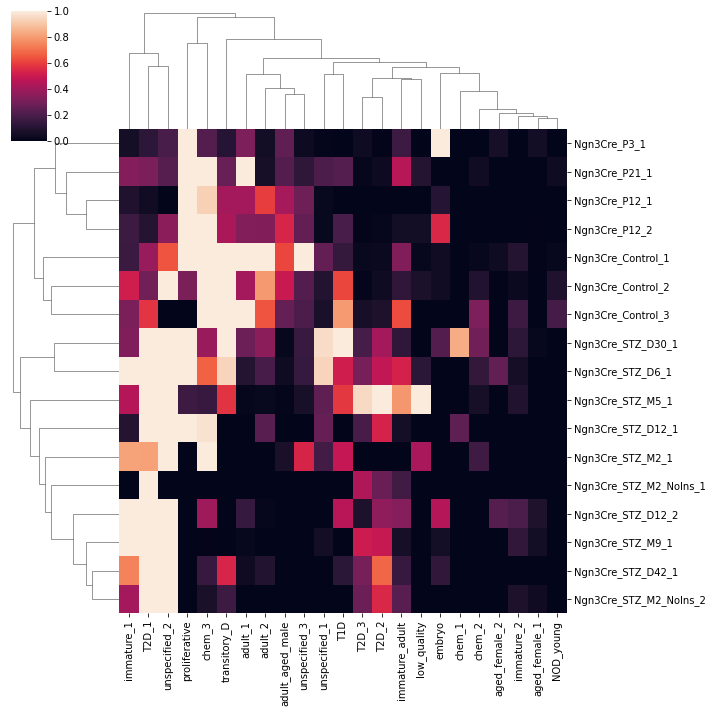

In [137]:
sb.clustermap(data)

C: P3 shares similarities with embryo and proliferative.

C: Query control cells are located between multiple ref clusters (including adult and chem).

C: PAGA may be problematic as we do not see per-cell predictions (there may be heterogeneity within samples, which are in query groupped in a single ct).